<a href="https://colab.research.google.com/github/andersenthomas98/timeseries-forecasting/blob/main/Lag_Llama_Zero_Shot_Forecasting_Daily_Climate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimenting with Lag-Llama on Daily Climate dataset

Zero shot forecasting using the Daily Climate dataset from kaggle. The foundational model is only used (no fine-tuning) on a dataset consisting of daily averages of temperature, humidity, wind speed and pressure readings in Delhi.

Daily Climate time series data: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

Lag-Llama: https://github.com/time-series-foundation-models/lag-llama/tree/main



Clone Lag-Llama repository:

In [1]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 178 (delta 52), reused 59 (delta 42), pack-reused 99
Receiving objects: 100% (178/178), 201.23 KiB | 16.77 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [2]:
cd lag-llama

/content/lag-llama


In [3]:
!pip install -r requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 52.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This

Download pretrained model weights from hugging face: https://huggingface.co/time-series-foundation-models/Lag-Llama

In [4]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
downloading https://huggingface.co/time-series-foundation-models/Lag-Llama/resolve/main/lag-llama.ckpt to /root/.cache/huggingface/hub/tmp3l5142jg
lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 228MB/s]
/content/lag-llama/lag-llama.ckpt


Import packages, and create a prediction function

In [5]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

def get_lag_llama_predictions(dataset, prediction_length, device, num_samples=100):
    ckpt = torch.load("lag-llama.ckpt", map_location=device)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=32, # Should not be changed; this is what the released Lag-Llama model was trained with

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Download daily climate time series dataset from kaggle


In [6]:
!pip install kaggle

In [8]:
from google.colab import userdata
from kaggle.api.kaggle_api_extended import KaggleApi
import os

# Setup environment variables for authenticating to kaggle using the kaggle API
kaggleUsername = userdata.get("KAGGLE_USERNAME")
kaggleKey = userdata.get("KAGGLE_KEY")
os.environ["KAGGLE_USERNAME"] = kaggleUsername
os.environ["KAGGLE_KEY"] = kaggleKey

# Authenticate
api = KaggleApi()
api.authenticate()

# Download dataset
datasetName = "sumanthvrao/daily-climate-time-series-data"
datasetPath = "/content/climate"
api.dataset_download_files(datasetName, path=datasetPath, unzip=True)



Plot climate dataset for inspection

/content/climate/DailyDelhiClimateTest.csv
             meantemp   humidity  wind_speed  meanpressure
date                                                      
2017-01-02  18.500000  77.222222    2.894444   1018.277778
2017-01-03  17.111111  81.888889    4.016667   1018.333333
2017-01-04  18.700000  70.050000    4.545000   1015.700000
2017-01-05  18.388889  74.944444    3.300000   1014.333333
2017-01-06  19.318182  79.318182    8.681818   1011.772727
meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object
datetime64[ns]
First date: 2017-01-02 00:00:00
Last date: 2017-04-24 00:00:00


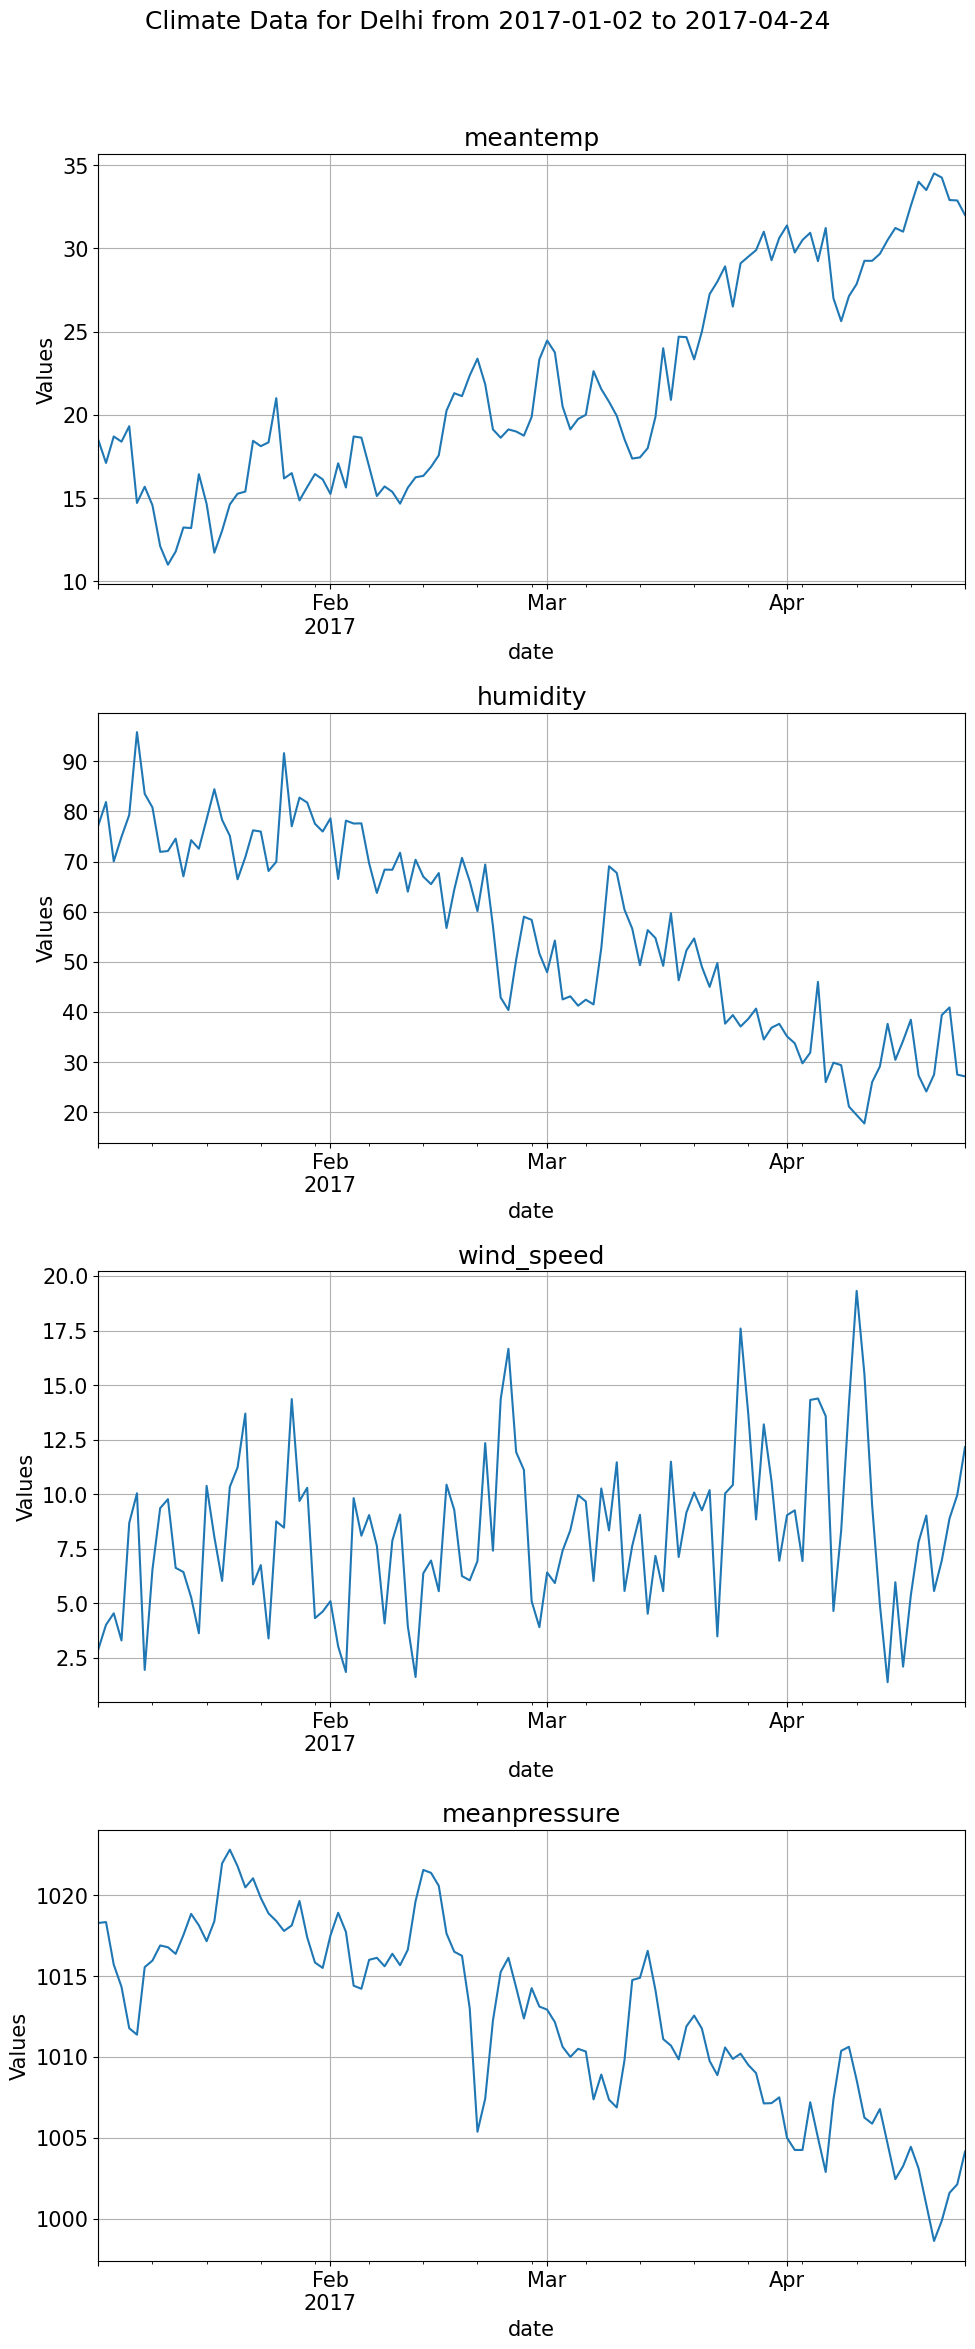

In [40]:
filePathTest = "{}/DailyDelhiClimateTest.csv".format(datasetPath)
print(filePathTest)

df = pd.read_csv(filePathTest, index_col=0, parse_dates=True)

# Remove the first row if it contains inaccurate data for mean pressure
df = df.iloc[1:]

# Print the DataFrame to verify its structure
print(df.head())  # Changed to head for brevity
print(df.dtypes)
print(df.index.dtype)

# Ensure all numerical columns are float32
for col in df.columns:
    if df[col].dtype != "object" and not pd.api.types.is_string_dtype(df[col]):
        df[col] = df[col].astype("float32")

# Get the first date
first_date = df.index.min()
print(f"First date: {first_date}")

# Get the last date
last_date = df.index.max()
print(f"Last date: {last_date}")

# Plotting all series in individual subplots in the DataFrame
fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(10, 6 * len(df.columns)))  # Adjust the size accordingly

for i, col in enumerate(df.columns):
    df[col].plot(ax=axes[i], title=col)
    axes[i].set_ylabel("Values")
    axes[i].grid(True)

# Add a general title
plt.suptitle('Climate Data for Delhi from {} to {}'.format(first_date.strftime('%Y-%m-%d'), last_date.strftime('%Y-%m-%d')))

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the rectangle in which to fit subplots

# Show the plot
plt.show()

In [31]:
# Create a PandasDataset
ds = PandasDataset(dict(df))
prediction_length = 30 # dataset has daily frequency, predict 30 days ahead
num_samples = 100 # number of samples sampled from the probability distribution for each timestamp
device = torch.device("cuda:0") # You can switch this to CPU or other GPUs depending on your environment

In [32]:
# Compute predictions
forecasts, tss = get_lag_llama_predictions(ds, prediction_length, device, num_samples)


In [41]:
print(forecasts)
print(tss)

print("Length of forecasts: {}".format(len(forecasts)))

print("Shape of forecasts: {}".format(forecasts[0].samples.shape))

[gluonts.model.forecast.SampleForecast(info=None, item_id='meantemp', samples=array([[23.501331, 18.711782, 20.768105, ..., 18.83125 , 18.415646,
        18.681644],
       [21.688444, 21.513866, 23.317951, ..., 18.434511, 19.003393,
        18.114168],
       [24.410051, 21.952868, 21.56759 , ..., 18.153008, 16.923714,
        17.464573],
       ...,
       [24.018675, 21.476685, 20.51591 , ..., 19.7543  , 18.308685,
        18.505583],
       [23.160221, 21.877079, 20.26027 , ..., 17.464827, 18.265575,
        18.086443],
       [18.80437 , 19.46732 , 18.873589, ..., 17.996717, 17.930054,
        16.737247]], dtype=float32), start_date=Period('2017-03-26', 'D')), gluonts.model.forecast.SampleForecast(info=None, item_id='humidity', samples=array([[47.161194, 46.608322, 52.418686, ..., 66.74206 , 66.70972 ,
        72.75302 ],
       [49.43029 , 51.929523, 53.686337, ..., 66.319016, 63.440643,
        62.556072],
       [40.407845, 50.188107, 40.350235, ..., 78.54487 , 76.729294,
     

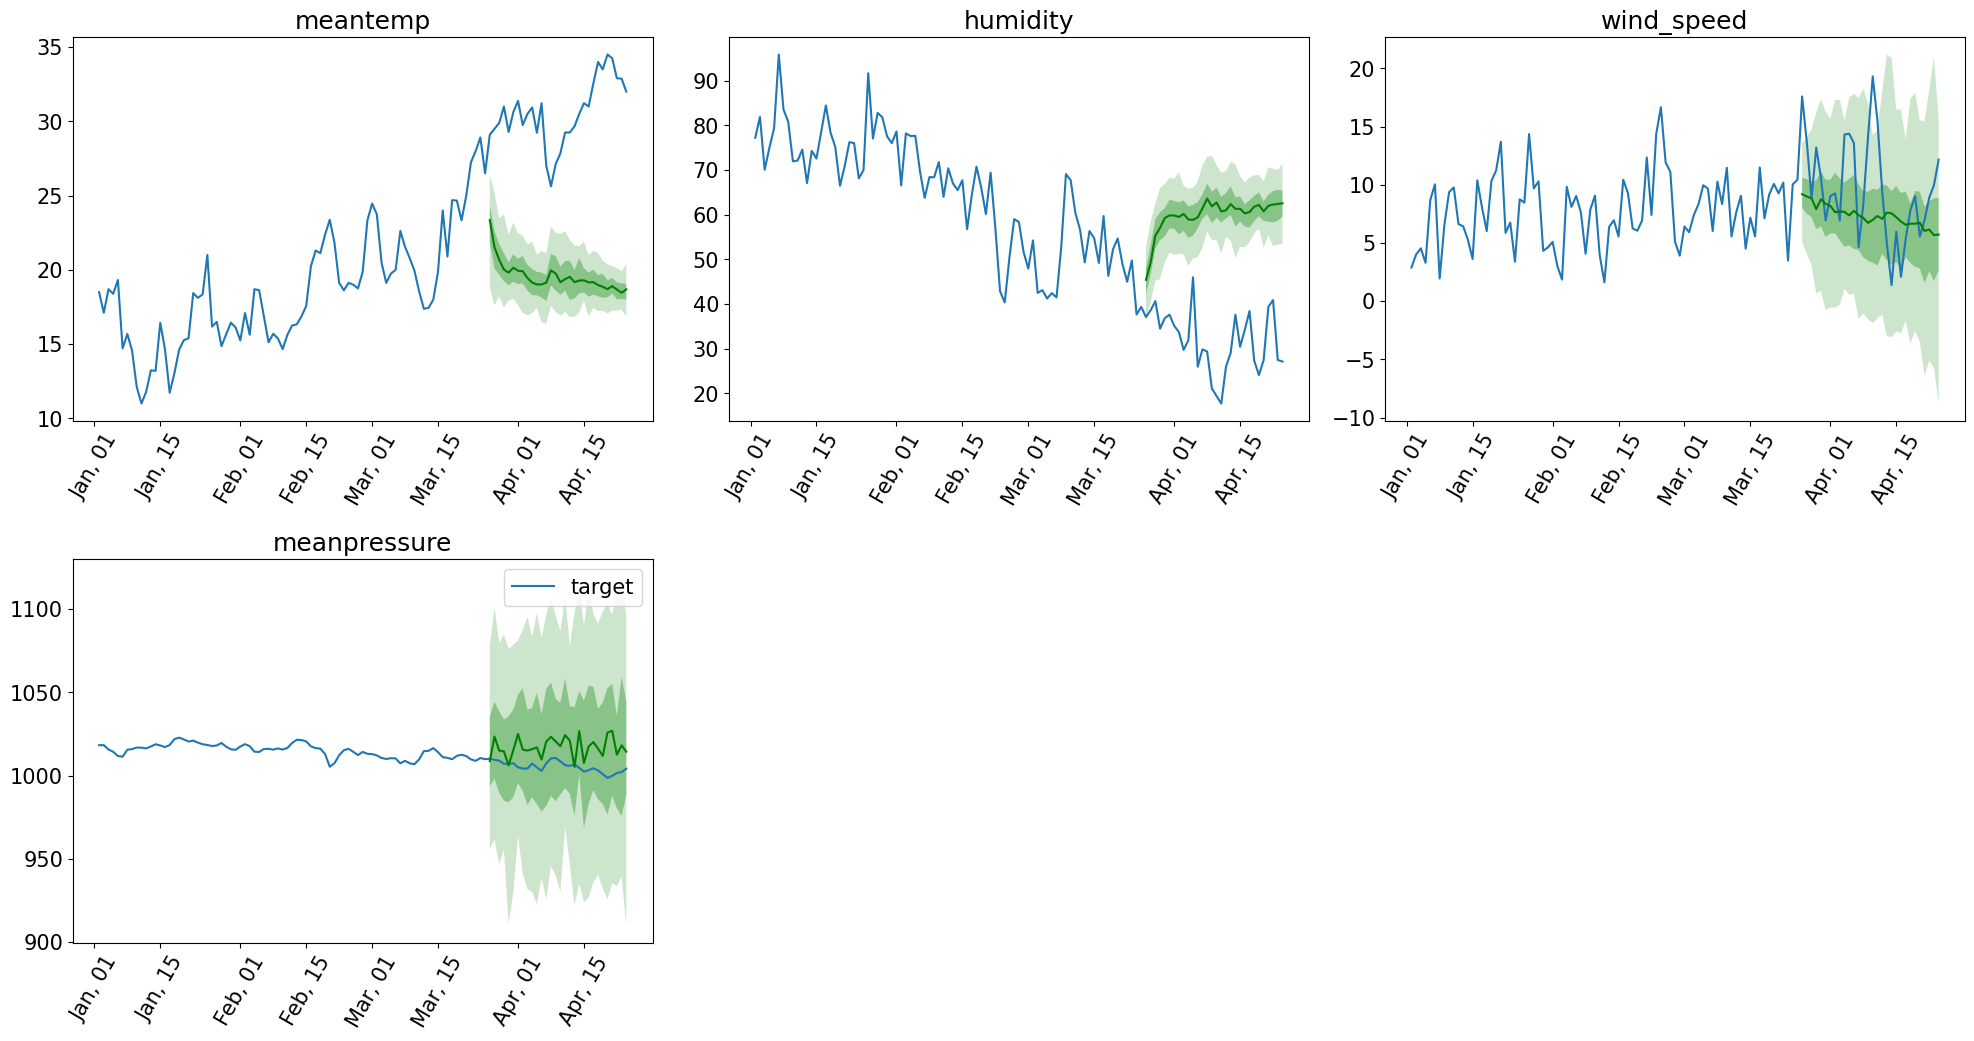

In [39]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 4 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 4):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [37]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 4it [00:00, 162.35it/s]


In [38]:
agg_metrics

{'MSE': 289.26894022623696,
 'abs_error': 1644.1105728149414,
 'abs_target_sum': 32322.58413696289,
 'abs_target_mean': 269.3548678080241,
 'seasonal_error': 2.959926419141816,
 'MASE': 5.492107497982892,
 'MAPE': 0.46992551386356357,
 'sMAPE': 0.37632619018356006,
 'MSIS': 122.4661345220046,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 1606.4455410480498,
 'Coverage[0.1]': 0.25,
 'QuantileLoss[0.2]': 1703.0135669708252,
 'Coverage[0.2]': 0.26666666666666666,
 'QuantileLoss[0.3]': 1591.8694663047786,
 'Coverage[0.3]': 0.2833333333333334,
 'QuantileLoss[0.4]': 1499.7543878555296,
 'Coverage[0.4]': 0.42500000000000004,
 'QuantileLoss[0.5]': 1644.1105742454529,
 'Coverage[0.5]': 0.55,
 'QuantileLoss[0.6]': 1719.7601928710938,
 'Coverage[0.6]': 0.5833333333333333,
 'QuantileLoss[0.7]': 1690.7641854286194,
 'Coverage[0.7]': 0.6333333333333333,
 'QuantileLoss[0.8]': 1526.4567483901974,
 'Coverage[0.8]': 0.6583333333333333,
 'QuantileLoss[0.9]': 1176.5320197105407,
 'Coverage[0.9]'